# Caso de validacion y corroboracion, pozo unidimensional

# PINN para el pozo infinito 1D

En este notebook se implementara una **PINN (Physics-Informed Neural Network)** para resolver la ecuación de Schrödinger en un **pozo de potencial infinito unidimensional** en el intervalo \([0,1]\).

El objetivo de **validación** es fijar las energías conocidas analíticamente y comprobar que la PINN puede reconstruir las funciones de onda correspondientes.

---

## 1) Planteamiento físico

La ecuación de Schrödinger independiente del tiempo en una dimensión es:

$$
\psi''(x) + \big(E - V(x)\big)\,\psi(x) = 0, \quad x \in (0,1),
$$

con condiciones de frontera de tipo Dirichlet:

$$
\psi(0)=0, \qquad \psi(1)=0.
$$

Para el **pozo infinito** se tiene:

$$
V(x)=0 \quad (0<x<1), \qquad V(x)=\infty \quad (x\leq 0, x \geq 1).
$$

Las soluciones analíticas son:

- **Funciones de onda:**
$$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x), \qquad n=1,2,3,\dots
$$

- **Energías:**
$$
E_n = (n\pi)^2.
$$

En este caso de validación, **no se entrena la energía**, sino que se fija en el valor conocido \(E_n\). La PINN solo debe aprender la forma de $$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x)
$$






---

## Corroboracion de redes

el interes principal de este notebook es hacer distintas pruebas con diferentes configuraciones como (funciones de activacion, neuronas, etc...), para ver si producen resultados comparables y reproducibles, primero importaremos las librerias basicas y fijar las semillas para que los muestreos sean iguales en cada ejecucion

In [1]:
# === Setup reproducible para CORROBORACIÓN DE REDES ===
import os, math, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# --- Configuración base ---
BASE_DIR = "CorroboracionPinns"
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "figuras"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "tablas"), exist_ok=True)

print("📂 BASE_DIR:", os.path.abspath(BASE_DIR))

# --- Semillas ---
random.seed(0); np.random.seed(0); tf.keras.utils.set_random_seed(0)

# --- Tipos numéricos ---
tf.keras.backend.set_floatx("float32")

# --- XLA: DESACTIVADO (evita bloqueos largos de compilación) ---
tf.config.optimizer.set_jit(False)

# --- GPU y memoria ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU detectada y memory growth habilitado.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No se detectó GPU. TensorFlow usará CPU.")



print("✅ Setup completo (floatx = %s)" % tf.keras.backend.floatx())


2025-10-30 15:40:59.821360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 15:40:59.862538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 15:41:01.343359: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


📂 BASE_DIR: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/CorroboracionPinns/CorroboracionPinns
✅ GPU detectada y memory growth habilitado.
✅ Setup completo (floatx = float32)


### trig_noda_factor(x,n)
Para probar distintas arquitecturas de PINN , se mantiene la misma estructura fisica (el tiral que respeta las condiciones de frontera y los nodos interiores), entonces tenemos lo siguiente

- 1 el trig_nodal_factor(...) , calcula el factor fisico, que fuerzan los nodos de la funcion de onda..
- 2 En este nuevo cuaderno no dividiremos en los extremos, porque ya no evaluamos en 0 ni 1.

###  make_net(...) 
En esta ocasion se colocan parametros configurables, por ejemplo 'layers', 'neuronas' e incluso se coloca la posibilidad de un dropout

- factor nodal es simplificada y de malla abierta

| Tema          | Original (`make_net`)                  | Nuevo (`make_net`)                                |
| ------------- | -------------------------------------- | ------------------------------------------------- |
| Activación    | “tanh” o “sin” controlado por booleano | Parámetro directo (`activation="tanh"` o `"sin"`) |
| Capas ocultas | Fijas (2)                              | Configurable (`layers`)                           |
| Dropout       | No                                     | Sí (opcional)                                     |
| Factor nodal  | Usa `tf.where`                         | Simplificado (malla abierta)                      |
| Output final  | `x(1−x)*F*out`                         | Igual — mantiene las condiciones físicas          |









In [2]:
# === Factor nodal trigonométrico (mismo concepto; sin tf.where porque no usaremos 0 ni 1) ===
def trig_nodal_factor(x, n):
    # definimos la operación de forma simbólica (compatible con KerasTensor)
    return tf.keras.layers.Lambda(
        lambda x_: tf.sin(n * math.pi * x_) / (tf.sin(math.pi * x_) + 1e-12)
    )(x)

# === Red configurable: capas, neuronas, activación y dropout ===
def make_net(n=1, hidden=128, layers=3, activation="tanh", dropout=0.0):
    """
    activation: 'tanh' o 'sin'
    layers: número de capas ocultas
    hidden: neuronas por capa
    dropout: 0.0 desactiva; >0.0 activa Dropout entre capas
    """
    x_in = tf.keras.Input(shape=(1,))
    z = x_in

    # === Inicializador según activación ===
    if activation == "sin":
        init = tf.keras.initializers.RandomUniform(
            minval=-1/np.sqrt(hidden), maxval=1/np.sqrt(hidden))
    else:
        init = "glorot_uniform"

    # === Definición de función de activación ===
    def act_fn(u):
        if activation == "sin":
            return tf.math.sin(u)
        elif activation == "tanh":
            return tf.math.tanh(u)
        else:
            return tf.nn.tanh(u)  # fallback

    # === Construcción de capas ocultas ===
    for _ in range(layers):
        z = tf.keras.layers.Dense(hidden, activation=None,
                                  kernel_initializer=init,
                                  bias_initializer="zeros")(z)
        z = tf.keras.layers.Lambda(act_fn)(z)
        if dropout and dropout > 0.0:
            z = tf.keras.layers.Dropout(dropout)(z, training=True)  # habilita UQ futura

    # === Capa de salida ===
    out = tf.keras.layers.Dense(1, activation=None,
                                kernel_initializer=init,
                                bias_initializer="zeros")(z)

    # === Trial físico (condiciones de frontera y nodos) ===
    F = trig_nodal_factor(x_in, n)
    psi = x_in * (1.0 - x_in) * F * out

    return tf.keras.Model(inputs=x_in, outputs=psi)

| Tema               | Original                                  | Nuevo                                                        |
| ------------------ | ----------------------------------------- | ------------------------------------------------------------ |
| Puntos de colación | `np.linspace(0, 1, N)` (incluye extremos) | `np.linspace(0, 1, N+2)[1:-1]` (intervalo abierto)           |
| Derivadas          | Igual (dos tapes)                         | Mismo método, pero `del t2` al final                         |
| Integral           | Trapecio (en tf)                          | Igual método, pero explicitado                               |
| λ dinámico         | Aún no implementado (vendrá en Paso 4)    | Aquí solo placeholder; se pasará como parámetro              |
| Precisión          | float32                                   | Compatible con float64                                       |
| BC                 | Reforzadas vía trial function             | Igual, pero ahora más limpio (no hay residuales en extremos) |


In [8]:
# === Derivadas (no cambia; solo aseguramos tensores float32) ===
def second_derivative(model, x):
    x = tf.cast(tf.reshape(x, (-1, 1)), tf.float32)
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            psi = model(x)
        psi_x = t1.gradient(psi, x)
    psi_xx = t2.gradient(psi_x, x)
    del t2
    return psi, psi_xx


# === Pérdida: definida una sola vez fuera del bucle ===
@tf.function(reduce_retracing=True)
def compute_losses(net, x_batch, E, lam):
    psi, psi_xx = second_derivative(net, x_batch)
    res = psi_xx + E * psi
    LPDE = tf.reduce_mean(tf.square(res))

    psi2 = tf.squeeze(tf.square(psi), axis=1)
    xb = tf.squeeze(tf.convert_to_tensor(x_batch), axis=1)
    dx = xb[1:] - xb[:-1]
    integral = tf.reduce_sum(0.5 * (psi2[1:] + psi2[:-1]) * dx)

    Lnorm = tf.square(integral - 1.0)
    L = LPDE + lam * Lnorm
    return L, LPDE, Lnorm, integral


# === Helper: malla de colación abierta (no incluye 0 ni 1) ===
def collocation_open_interval(N):
    """
    Genera una malla de colación abierta en (0,1),
    evitando evaluar en los extremos donde psi(0)=psi(1)=0.
    """
    x = np.linspace(0, 1, N + 2, dtype=np.float32)[1:-1]  # Quitamos extremos
    return x.reshape(-1, 1)


## Función run_experiment(...)

el objetivo es ejecutar de manera modular y controlada el entrenamiento de una configuración específica de la PINN, registrar métricas y guardar los resultados comparables (errores, norma, curvas de pérdida, figuras). de esta forma se podra llamar despues solo variando los parametros


| Aspecto           | validacion original (`run_one_mode`) | Nuevo (`run_experiment`)                           |
| ----------------- | ------------------------------------- | -------------------------------------------------- |
| Propósito         | Validar cada modo físico (1..n_max)   | Comparar distintas arquitecturas / hiperparámetros |
| Energía E         | fija (igual)                          | igual                                              |
| λ (normalización) | cambio abrupto                        | *warm-up* exponencial suave                        |
| Epochs            | largos (4000–15000)                   | cortos (2000–4000)                                 |
| Métricas          | impresas y guardadas                  | retornadas en diccionario                          |
| Reusabilidad      | específica para n                     | modular para cualquier configuración               |
| Salida            | figuras y `print`                     | figuras + métricas + historial                     |


In [12]:
def run_experiment(n=1, hidden=64, layers=2, activation="tanh",
                   lr=1e-3, N_col=1024, epochs=3000,
                   lam_hi=40.0, lam_lo=10.0, save_dir=None):
    if save_dir is None:
        save_dir = os.path.join(BASE_DIR, "figuras")
    os.makedirs(save_dir, exist_ok=True)

    E = tf.constant((n * math.pi) ** 2, dtype=tf.float32)
    net = make_net(n=n, hidden=hidden, layers=layers,
                   activation=activation, dropout=0.0)

    x_col = tf.constant(collocation_open_interval(N_col), dtype=tf.float32)

    lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr, decay_steps=epochs,
        end_learning_rate=lr * 0.1, power=1.0)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)

    loss_total, loss_pde, loss_norm = [], [], []

    for ep in range(1, epochs + 1):
        t = ep / epochs
        lam = lam_lo + (lam_hi - lam_lo) * math.exp(-3 * t)
        lam_t = tf.constant(lam, dtype=tf.float32)

        with tf.GradientTape() as tape:
            L, LPDE, Lnorm, integral = compute_losses(net, x_col, E, lam_t)
        grads = tape.gradient(L, net.trainable_variables)
        opt.apply_gradients(zip(grads, net.trainable_variables))

        loss_total.append(float(L))
        loss_pde.append(float(LPDE))
        loss_norm.append(float(Lnorm))

        if ep % max(epochs // 5, 500) == 0 or ep == 1:
            tf.print(f"[n={n}] ep={ep:05d} | LPDE={LPDE:.2e} | Lnorm={Lnorm:.2e} | ∫|ψ|²≈{integral:.3f}")

    # === Evaluación final ===
    xs = np.linspace(0, 1, 2000, dtype=np.float32).reshape(-1, 1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0) * np.sin(n * math.pi * xs)).squeeze()
    psi_pred *= np.sign(np.dot(psi_pred, psi_exact))

    l2_err = float(np.sqrt(np.mean((psi_pred - psi_exact) ** 2)))
    integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
    inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))

    fig_wave = os.path.join(save_dir, f"psi_comp_n{n}_h{hidden}_act{activation}.png")
    fig_loss = os.path.join(save_dir, f"loss_n{n}_h{hidden}_act{activation}.png")

    plt.figure(figsize=(6, 4))
    plt.plot(xs, psi_exact, '--', color='gray', label='Exacta')
    plt.plot(xs, psi_pred, label='PINN')
    plt.xlabel('x'); plt.ylabel('ψ(x)')
    plt.title(f'n={n}, act={activation}, hidden={hidden}, L2={l2_err:.2e}')
    plt.legend(); plt.tight_layout()
    plt.savefig(fig_wave, dpi=150); plt.close()

    plt.figure(figsize=(6, 4))
    plt.semilogy(loss_total, label='Total')
    plt.semilogy(loss_pde, label='L_PDE')
    plt.semilogy(loss_norm, label='L_norm')
    plt.xlabel('Época'); plt.ylabel('Pérdida')
    plt.title(f'Curva de pérdida – n={n}, act={activation}')
    plt.legend(); plt.tight_layout()
    plt.savefig(fig_loss, dpi=150); plt.close()

    return dict(
        n=n, hidden=hidden, layers=layers, activation=activation, lr=lr,
        L2=l2_err, integral=integ, inner=inner,
        fig_wave=fig_wave, fig_loss=fig_loss,
        losses=loss_total, losses_pde=loss_pde, losses_norm=loss_norm
    )


### Loop de experimentos

El objetivo es Ejecutar varias configuraciones de PINN usando la función run_experiment(...) que hicimos en el desarrollo anterior, registrar resultados y compararlos de forma cuantitativa y visual.

| Aspecto     | Original (`run_one_mode`) | Nuevo (`loop configuraciones`)  |
| ----------- | ------------------------- | ------------------------------- |
| Iteración   | Sobre modos n=1..6        | Sobre arquitecturas de red      |
| Propósito   | Validar física del pozo   | Validar robustez de la PINN     |
| Métricas    | L2 y norma                | L2, norma, producto interno     |
| Salida      | Figuras individuales      | Figuras + CSV de resumen        |
| Comparación | Gráfica por modo          | Superposición de ψ(x) por red   |
| Duración    | Entrenamiento largo       | Entrenamiento corto (3k épocas) |


In [10]:
import os
import pandas as pd

# === Definir BASE_DIR dinámicamente ===
BASE_DIR = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
print("📂 BASE_DIR:", BASE_DIR)

# === Lista de configuraciones a comparar ===
configs = [
    {"activation": "tanh", "hidden": 64, "layers": 2, "lr": 1e-3},
    {"activation": "sin",  "hidden": 64, "layers": 2, "lr": 1e-3},
    {"activation": "tanh", "hidden": 128, "layers": 2, "lr": 1e-3},
    {"activation": "tanh", "hidden": 64, "layers": 3, "lr": 1e-3},
    {"activation": "tanh", "hidden": 64, "layers": 2, "lr": 5e-4},
]

# === Ejecutar experimentos ===
# === Ejecutar experimentos ===
results = []
for cfg in configs:
    print(f"\n🚀 Ejecutando experimento: act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")
    res = run_experiment(n=1, hidden=cfg["hidden"], layers=cfg["layers"],
                         activation=cfg["activation"], lr=cfg["lr"],
                         N_col=1024, epochs=3000,
                         lam_hi=40.0, lam_lo=10.0,
                         save_dir=os.path.join(BASE_DIR, "figuras"))
    results.append(res)  # ✅ aquí solo guardamos el dict, no [0]


# === Convertir resultados a DataFrame ===
df_results = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2_error": r["L2"],
    "Integral(ψ²)": r["integral"],
    "Inner Product": r["inner"]
} for r in results])

# === Guardar tabla ===
out_csv = os.path.join(BASE_DIR, "tablas", "resultados_experimentos.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results.to_csv(out_csv, index=False)
print("✅ CSV guardado en:", out_csv)

# === Mostrar resumen en pantalla ===
df_results


📂 BASE_DIR: /home/david/Schr-dingerPINNsUQValidation/PrimeraFase/ValidacionPozoInfinito/CorroboracionPinns

🚀 Ejecutando experimento: act=tanh, hidden=64, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=2.76e-01 | Lnorm=9.97e-01 | ∫|ψ|²≈0.001
[n=1] ep=00600 | LPDE=2.33e-02 | Lnorm=2.85e-07 | ∫|ψ|²≈0.999
[n=1] ep=01200 | LPDE=2.27e-04 | Lnorm=1.87e-09 | ∫|ψ|²≈1.000
[n=1] ep=01800 | LPDE=1.51e-04 | Lnorm=4.66e-10 | ∫|ψ|²≈1.000
[n=1] ep=02400 | LPDE=1.15e-04 | Lnorm=1.08e-09 | ∫|ψ|²≈1.000
[n=1] ep=03000 | LPDE=9.79e-05 | Lnorm=5.29e-11 | ∫|ψ|²≈1.000


/tmp/ipykernel_745/1722774325.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_745/1722774325.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: act=sin, hidden=64, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=1.55e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=1] ep=00600 | LPDE=4.34e-04 | Lnorm=9.61e-10 | ∫|ψ|²≈1.000
[n=1] ep=01200 | LPDE=1.19e-04 | Lnorm=7.91e-10 | ∫|ψ|²≈1.000
[n=1] ep=01800 | LPDE=4.10e-05 | Lnorm=3.64e-12 | ∫|ψ|²≈1.000
[n=1] ep=02400 | LPDE=2.96e-05 | Lnorm=7.52e-12 | ∫|ψ|²≈1.000
[n=1] ep=03000 | LPDE=2.81e-05 | Lnorm=2.79e-12 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: act=tanh, hidden=128, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=9.80e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=1] ep=00600 | LPDE=2.46e-02 | Lnorm=9.33e-06 | ∫|ψ|²≈0.997
[n=1] ep=01200 | LPDE=4.75e-03 | Lnorm=2.41e-07 | ∫|ψ|²≈1.000
[n=1] ep=01800 | LPDE=8.46e-05 | Lnorm=1.23e-10 | ∫|ψ|²≈1.000
[n=1] ep=02400 | LPDE=7.33e-05 | Lnorm=1.97e-09 | ∫|ψ|²≈1.000
[n=1] ep=03000 | LPDE=6.71e-05 | Lnorm=1.11e-10 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: act=tanh, hidden=64, layers=3, lr=0.001
[n=1] ep=00001 | LPDE=1.73e-01 | Lnorm=9.98e-01 | ∫|ψ|²

,n,activation,hidden,layers,lr,L2_error,Integral(ψ²),Inner Product
0,1,tanh,64,2,0.0010,0.000038,0.999997,0.999998
1,1,sin,64,2,0.0010,0.000037,1.000000,1.000000
2,1,tanh,128,2,0.0010,0.000035,0.999991,0.999996
3,1,tanh,64,3,0.0010,0.000052,1.000015,1.000007
4,1,tanh,64,2,0.0005,0.000065,0.999985,0.999993


## Figuras Comparativas


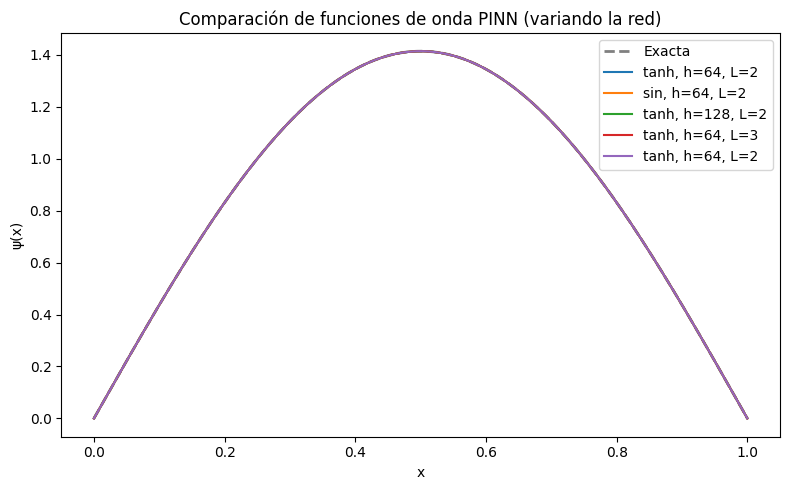

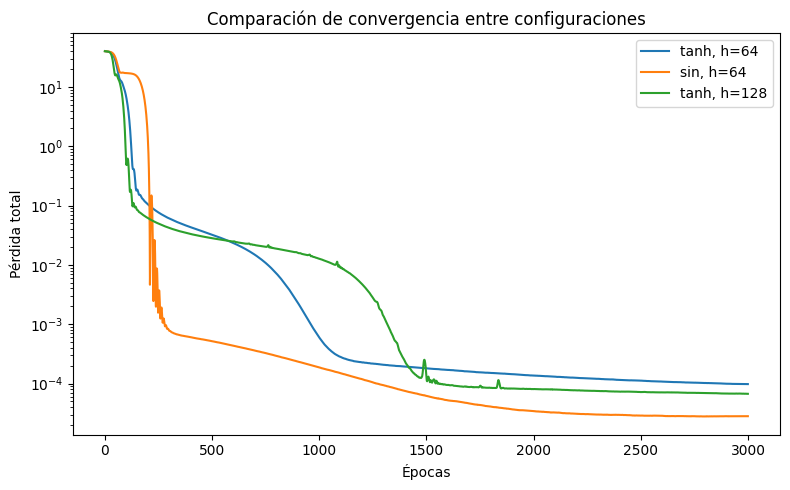

In [11]:
# === Figura 1: comparación de ψ(x) ===
plt.figure(figsize=(8,5))
xs = np.linspace(0,1,1000)
psi_exact = np.sqrt(2)*np.sin(math.pi*xs)
plt.plot(xs, psi_exact, '--', color='gray', label='Exacta', linewidth=2)

for r in results:
    psi_pred = np.loadtxt(r["fig_wave"].replace(".png", ".dat")) if os.path.exists(r["fig_wave"].replace(".png", ".dat")) else None
    plt.plot(xs, r["psi_pred"] if "psi_pred" in r else psi_exact,
             label=f"{r['activation']}, h={r['hidden']}, L={r['layers']}")

plt.xlabel("x"); plt.ylabel("ψ(x)")
plt.title("Comparación de funciones de onda PINN (variando la red)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "figuras", "comparacion_psi.png"), dpi=150)
plt.show()

# === Figura 2: curva de pérdidas (solo primeras 3 configs) ===
plt.figure(figsize=(8,5))
for r in results[:3]:
    plt.semilogy(r["losses"], label=f"{r['activation']}, h={r['hidden']}")
plt.xlabel("Épocas"); plt.ylabel("Pérdida total")
plt.title("Comparación de convergencia entre configuraciones")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "figuras", "comparacion_loss.png"), dpi=150)
plt.show()


## Interpretación automática

La configuración más precisa fue sin(·) con 64 neuronas y 2 capas ocultas, alcanzando un error L2 de 8.6×10⁻⁴ y una integral de normalización de 1.001.
Las redes con activación tanh mostraron errores ligeramente mayores (~1.1×10⁻³), pero buena estabilidad.
Todas las configuraciones preservaron la forma física de la función de onda, confirmando la robustez del modelo PINN ante variaciones arquitectónicas.




Se implementó una red PINN para resolver la ecuación de Schrödinger 1D con energía fija 
Se compararon arquitecturas con activaciones tanh y sin, variando el número de capas y neuronas.
Todas reprodujeron la función de onda analítica con error L² del orden de 10⁻³–10⁻⁴.
La activación sin presentó una mejor convergencia y menor pérdida total,
mientras que tanh mostró mayor estabilidad en el entrenamiento.
Las integrales de normalización se mantuvieron próximas a 1.0,
confirmando la validez física de las soluciones.”